seeds:
 [[63.11570435 96.58913277]
 [68.75453751 88.50845366]
 [86.14859024 70.58836794]
 [45.39487811 64.37205303]
 [14.73901216 13.25479656]
 [24.49721465 97.72109572]
 [26.17834672 95.18349919]
 [ 5.96674766 11.15305455]
 [46.32023519 23.94235694]
 [32.89116565 41.99999611]
 [29.25323238 63.43902906]
 [51.76974542  3.26210571]
 [21.88239141 51.44129684]
 [10.43211622 73.74938303]
 [55.2779659  38.91811069]
 [73.33973151 78.62099815]
 [18.22493725 27.97185059]
 [28.78256273 76.31750248]
 [58.42337206 83.46588651]
 [72.06386603 89.67920262]
 [83.83906584 71.91851797]
 [80.7350679  38.86173119]
 [18.87622136 95.20982832]
 [76.33367245 54.04739658]]
BBox Min: [5.96674766 3.26210571] Bbox Max:  [86.14859024 97.72109572]
37 Delaunay triangles


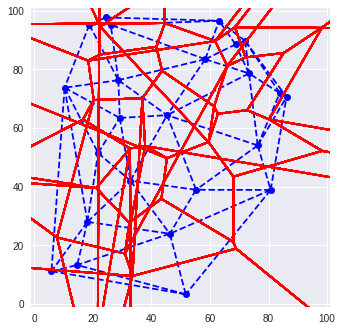

In [4]:
import numpy as np
from math import sqrt


class Delaunay2D:

    def __init__(self, center=(0, 0), radius=9999):

        center = np.asarray(center)

        self.coords = [center+radius*np.array((-1, -1)),
                       center+radius*np.array((+1, -1)),
                       center+radius*np.array((+1, +1)),
                       center+radius*np.array((-1, +1))]

        self.triangles = {}
        self.circles = {}

        T1 = (0, 1, 3)
        T2 = (2, 3, 1)
        self.triangles[T1] = [T2, None, None]
        self.triangles[T2] = [T1, None, None]

        for t in self.triangles:
            self.circles[t] = self.circumcenter(t)

    def circumcenter(self, tri):

        pts = np.asarray([self.coords[v] for v in tri])
        pts2 = np.dot(pts, pts.T)
        A = np.bmat([[2 * pts2, [[1],
                                 [1],
                                 [1]]],
                      [[[1, 1, 1, 0]]]])

        b = np.hstack((np.sum(pts * pts, axis=1), [1]))
        x = np.linalg.solve(A, b)
        bary_coords = x[:-1]
        center = np.dot(bary_coords, pts)

        radius = np.sum(np.square(pts[0] - center))
        return (center, radius)

    def inCircleFast(self, tri, p):

        center, radius = self.circles[tri]
        return np.sum(np.square(center - p)) <= radius

    def inCircleRobust(self, tri, p):

        m1 = np.asarray([self.coords[v] - p for v in tri])
        m2 = np.sum(np.square(m1), axis=1).reshape((3, 1))
        m = np.hstack((m1, m2))  
        return np.linalg.det(m) <= 0

    def addPoint(self, p):

        p = np.asarray(p)
        idx = len(self.coords)
        self.coords.append(p)

        bad_triangles = []
        for T in self.triangles:
   
            if self.inCircleFast(T, p):
                bad_triangles.append(T)

        boundary = []
        T = bad_triangles[0]
        edge = 0

        while True:
          
            tri_op = self.triangles[T][edge]
            if tri_op not in bad_triangles:
               
                boundary.append((T[(edge+1) % 3], T[(edge-1) % 3], tri_op))

                edge = (edge + 1) % 3

                if boundary[0][0] == boundary[-1][1]:
                    break
            else:
                edge = (self.triangles[tri_op].index(T) + 1) % 3
                T = tri_op

        for T in bad_triangles:
            del self.triangles[T]
            del self.circles[T]

        new_triangles = []
        for (e0, e1, tri_op) in boundary:
            T = (idx, e0, e1)

            self.circles[T] = self.circumcenter(T)

            self.triangles[T] = [tri_op, None, None]

            if tri_op:
                for i, neigh in enumerate(self.triangles[tri_op]):
                    if neigh:
                        if e1 in neigh and e0 in neigh:
                            self.triangles[tri_op][i] = T

            new_triangles.append(T)

        N = len(new_triangles)
        for i, T in enumerate(new_triangles):
            self.triangles[T][1] = new_triangles[(i+1) % N]   # next
            self.triangles[T][2] = new_triangles[(i-1) % N]   # previous

    def exportTriangles(self):

        return [(a-4, b-4, c-4)
                for (a, b, c) in self.triangles if a > 3 and b > 3 and c > 3]

    def exportCircles(self):

        return [(self.circles[(a, b, c)][0], sqrt(self.circles[(a, b, c)][1]))
                for (a, b, c) in self.triangles if a > 3 and b > 3 and c > 3]

    def exportDT(self):

        coord = self.coords[4:]


        tris = [(a-4, b-4, c-4)
                for (a, b, c) in self.triangles if a > 3 and b > 3 and c > 3]
        return coord, tris

    def exportExtendedDT(self):

        return self.coords, list(self.triangles)

    def exportVoronoiRegions(self):

        useVertex = {i: [] for i in range(len(self.coords))}
        vor_coors = []
        index = {}

        for tidx, (a, b, c) in enumerate(self.triangles):
            vor_coors.append(self.circles[(a, b, c)][0])

            useVertex[a] += [(b, c, a)]
            useVertex[b] += [(c, a, b)]
            useVertex[c] += [(a, b, c)]

            index[(a, b, c)] = tidx
            index[(c, a, b)] = tidx
            index[(b, c, a)] = tidx


        regions = {}
        r = [];
        for i in range(4, len(self.coords)):
            v = useVertex[i][0][0]  
            for _ in range(len(useVertex[i])):
  
                t = [t for t in useVertex[i] if t[0] == v][0]
                r.append(index[t])  
                v = t[1]            
            regions[i-4] = r       

        return vor_coors, regions

      #Plot demo

if __name__ == '__main__':


    numSeeds = 24
    radius = 100
    seeds = radius * np.random.random((numSeeds, 2))
    print("seeds:\n", seeds)
    print("BBox Min:", np.amin(seeds, axis=0),
          "Bbox Max: ", np.amax(seeds, axis=0))


    center = np.mean(seeds, axis=0)
    dt = Delaunay2D(center, 50 * radius)
    

    for s in seeds:
        dt.addPoint(s)

    print (len(dt.exportTriangles()), "Delaunay triangles")
       

    import matplotlib.pyplot as plt
    import matplotlib.tri
    import matplotlib.collections


    fig, ax = plt.subplots()
    ax.margins(0.1)
    ax.set_aspect('equal')
    plt.axis([-1, radius+1, -1, radius+1])


    cx, cy = zip(*seeds)
    dt_tris = dt.exportTriangles()
    ax.triplot(matplotlib.tri.Triangulation(cx, cy, dt_tris), 'bo--')


    vc, vr = dt.exportVoronoiRegions()
    

    for r in vr:
        polygon = [vc[i] for i in vr[r]]       
        plt.plot(*zip(*polygon), color="red")

    plt.show()
 